<a href="https://colab.research.google.com/github/prasadmaharana/DCGAN-with-MNIST-dataset/blob/main/DCGAN_MNIST_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

GAN, when used to generate images with the help of a deep convolutional network, is termed as DCGAN (Deep Convolutional Generative Adversarial Network). Hence, all the properties of basic GAN are applied to DCGAN in the same manner. 

A DCGAN works similarly to GAN, but it specifically focuses on using convolutional neural networks in the place of those fully-connected networks. As you learnt earlier, conv nets, in general, find areas of correlation within an image, that is, they look for spatial correlations.


This means that a DCGAN would likely be more fitting for the image or video data. Whereas, the general idea of a GAN can be applied to wider domains, as the model specifics are left to be addressed by the individual model architectures.

##Pipeline

* Importing Libraries
* Data loading and Visualization
* Data Pre-processing
* Model Building
* Model Training
* Generate a GIF of Generated Images

##Importing Libraries

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import imageio
from IPython import display
from skimage.transform import resize
from keras.utils.vis_utils import plot_model

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = InteractiveSession(config=config)

##Load the MNIST dataset

In [ ]:
(train_images,train_label),(_,_)=tf.keras.datasets.mnist.load_data()


##Visualize a sample image

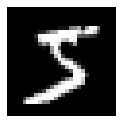

5
()


In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(train_images[0],cmap='gray')
plt.axis('off')
plt.show()
print(train_label[0])
print(train_label[0].shape)

##Declare Buffer size, batch size and dimensions of Noise

In [ ]:
BUFFER_SIZE=60000
BATCH_SIZE=300
NOISE_DIM=100

##Normalize the images between [-1,1]


Pixel Normalization with Zero Centre

In [ ]:
train_dataset=(train_images/127.5)-1.0

Dividing raw pixel values of range (0, 255) by 127.5 will make it in the range (0, 2) and when we subtract 1 from all the values, we get (-1, 1).

##Resize the Images

In [ ]:
train_images=np.zeros((BUFFER_SIZE,32,32))

for index,img in enumerate(train_dataset):
  train_images[index, :, :]=resize(img,(32,32))

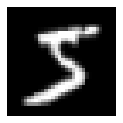

In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(train_images[0],cmap='gray')
plt.axis('off')
plt.show()

##Reshape to add the channel dimension

In [ ]:
train_images=train_images.reshape(train_images.shape[0],32,32,1).astype('float32')

##Shuffle data and store in batches

shuffle- randomly shuffle images of the dataset

batch- combines consecutive images of the dataset into batches 

In [ ]:
#batch and shuffle data
train_dataset=tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE,seed=42).batch(BATCH_SIZE)

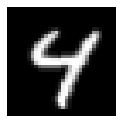

In [ ]:
#plot an image sample

sample=next(iter(train_dataset))

plt.figure(figsize=(2,2))
plt.imshow(sample[0].numpy()[:,:,0],cmap='gray')
plt.axis('off')
plt.show()

##Model Building

1. Generator Model 
2. Discriminator Model

###Generator Model Building using Transposed Convolutional Layer

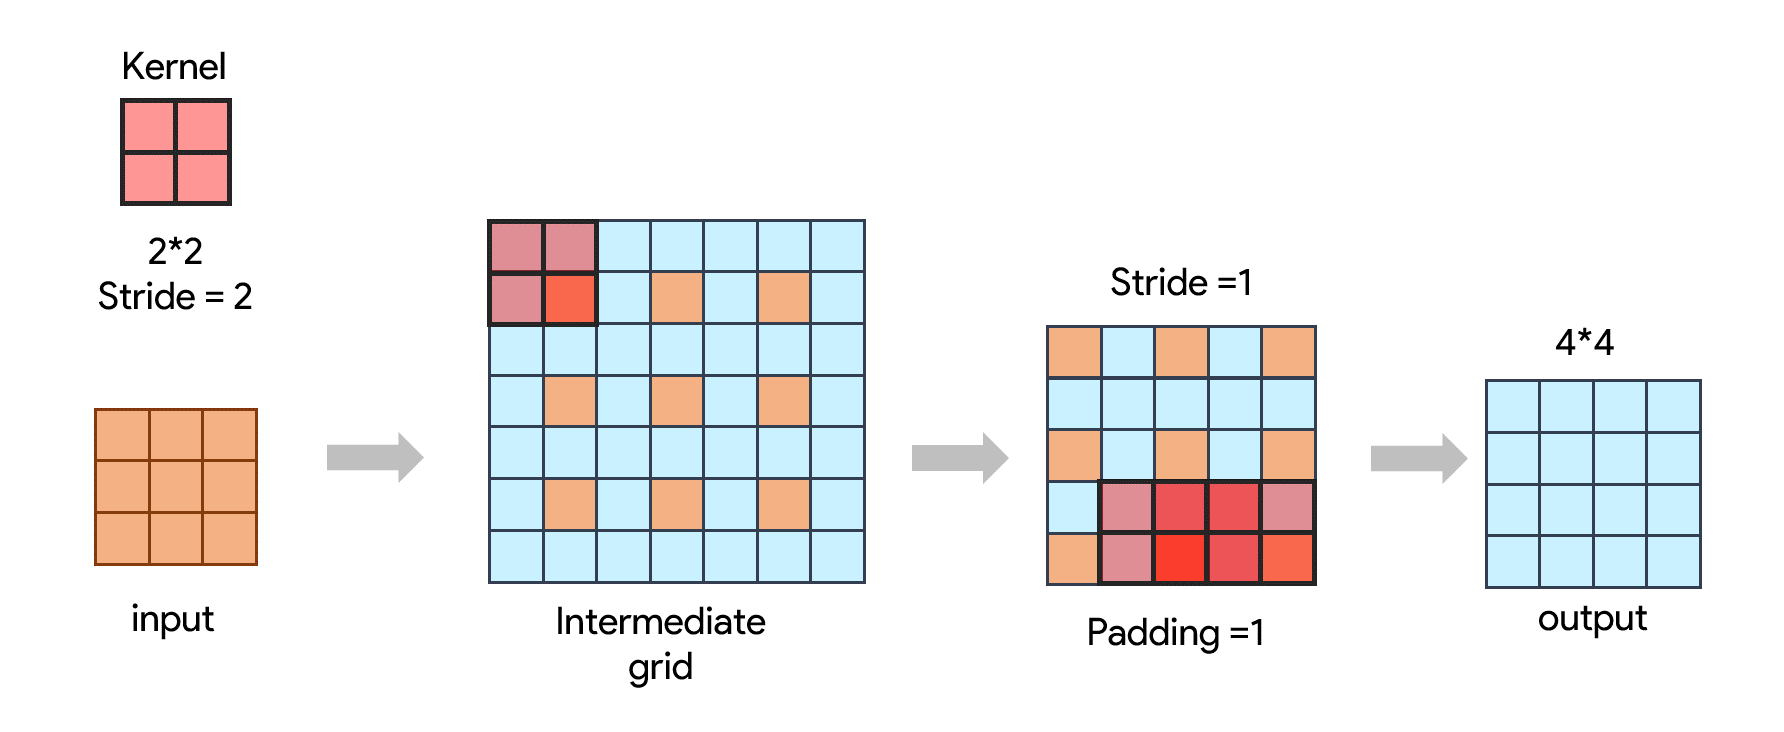

In [ ]:
def generator_model():
  model=tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(4*4*128,use_bias=False,input_shape=(NOISE_DIM,)))   #1 Dimensional
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Reshape((4,4,128)))

  model.add(tf.keras.layers.Conv2DTranspose(128,(3,3),strides=(2,2),use_bias=False,padding='same'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Conv2DTranspose(64,(3,3),strides=(2,2),use_bias=False,padding='same'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Conv2DTranspose(1,(3,3),strides=(2,2),use_bias=False,padding='same',activation='tanh'))

  return model

In [ ]:
generator=generator_model()
plot_model(generator,show_shapes=True,show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


###Generate Image through Random Noise

Untrained model will show noisy image

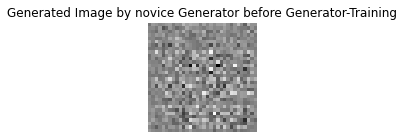

In [ ]:
constant_noise = tf.random.normal([1, NOISE_DIM])
generated_image = generator(constant_noise, training=False)

plt.figure(figsize=(2, 2))
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.title('Generated Image by novice Generator before Generator-Training')
plt.axis('off')
plt.show()

###Discriminator Model Building using Convolutional Layers

In [ ]:
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(16, (3, 3), strides=(1, 1), use_bias=False,input_shape=[32, 32, 1]))
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(256, (5, 5), strides=(2, 2), use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(1, (10, 10), strides=(1, 1)))

    model.add(tf.keras.layers.Flatten())

    return model

In [ ]:
discriminator=discriminator_model()
plot_model(discriminator,show_shapes=True,show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [ ]:
#predicting on untrained discriminator model

decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00061159]], shape=(1, 1), dtype=float32)


##Model Training

* Loss type
* Discriminator Loss
* Generator Loss
* Optimizer
* Checkpoint Initialization
* Training Flow

Declare Binary Cross Entropy Loss since we'll calculate Loss on Discriminator which is a classifier

In [ ]:
cross_entropy=tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Calculate Discriminator Loss

Discriminator Loss 
* Loss on Real data 
* Loss on Fake data

In [ ]:
def discriminator_loss(real_output,fake_output):
  real_loss=cross_entropy(tf.ones_like(real_output),real_output)
  fake_loss=cross_entropy(tf.zeros_like(fake_output),fake_output)
  total_loss=real_loss+fake_loss
  return total_loss

###Generator Loss

It has only one type of loss - Discriminator Loss on generated data

In [ ]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output),fake_output)

###Using Adam  optimizer

In [ ]:
generator_opt=tf.keras.optimizers.Adam(1e-4)
discriminator_opt=tf.keras.optimizers.Adam(1e-4)

We willl train our model for 250 epochs

In [ ]:
EPOCHS=200

###Check Point Initialization

Initialize checkpoints to save models

In [ ]:
# Directory to keep Generated Images each epoch

if not os.path.isdir('generated_images'):
  os.mkdir('generated_images')


  #Directory to save checkpoints
  checkpint_dir='./training_checkpoints'
  chkpt=tf.train.Checkpoint(generator_optimizer=generator_opt,discriminator_optimizer=discriminator_opt,generator=generator,discriminator=discriminator)

  chkpt_manager=tf.train.CheckpointManager(chkpt,checkpint_dir,max_to_keep=3)

  #if a checkpoint exists, restore the checkpoint

  if chkpt_manager.latest_checkpoint:
    chkpt.restore(chkpt_manager.latest_checkpoint)
    print('latest Checkpoint restored')

###Training Flow

Below Function performs one flow of batch training

In [ ]:
@tf.function
def train_step(images):
  #take noise input
  noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

  #Tracking gradients for calculation
  with tf.GradientTape() as gen_tape,tf.GradientTape() as disc_tape:
    #generate fake images from noise
    generated_images=generator(noise,training=True)

    #check the discriminator output for real and fake image
    real_output=discriminator(images,training=True)
    fake_output=discriminator(generated_images,training=True)

    #generator's loss on fake and discriminator's loss on both real and fake
    gen_loss = generator_loss(fake_output)
    disc_loss= discriminator_loss(real_output,fake_output)

  #calculate the Gradients
  grad_generator=gen_tape.gradient(gen_loss,generator.trainable_variables)
  grad_discriminator=disc_tape.gradient(disc_loss,discriminator.trainable_variables)

  #apply gradients in the optimizer
  generator_opt.apply_gradients(zip(grad_generator,generator.trainable_variables))
  discriminator_opt.apply_gradients(zip(grad_discriminator,discriminator.trainable_variables))



##Train the DCGAN model for several epochs

Loop training function for number of epochs and also show the output at each stage

Note how generator is getting better at producing realistic images epoch by epoch

In [ ]:
num_examples=16

#reusing the seed over time to visualize progress in animated gifs

seed=tf.random.normal([num_examples,NOISE_DIM])

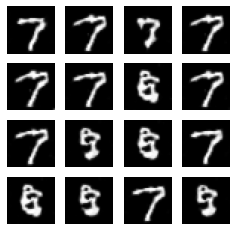

Saving checkpoint for epoch  200  at  ./training_checkpoints\ckpt-40000


In [ ]:
for epoch in range (1,EPOCHS+1):
  for image_batch in train_dataset:
    train_step(image_batch)

    #produce images to show progess in gif
    display.clear_output(wait=True)

    #training is set to false so all laters run in inference mode (batchnorm)
    predictions=generator(seed,training=False)

    fig=plt.figure(figsize=(4,4))

    for i in range (predictions.shape[0]):
      plt.subplot(4,4,i+1)
      plt.imshow(predictions[i,:,:,0]*127.5+127.5,cmap='gray')
      plt.axis('off')

    plt.savefig('image_at_epoch{:04d}.png'.format(epoch))
    plt.show()

    chkpt_savepath=chkpt_manager.save()
    print('Saving checkpoint for epoch ',epoch,' at ',chkpt_savepath)


##Generating a GIF of generated Images

In [3]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [ ]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to c:\users\prasad_maharana\appdata\local\temp\pip-req-build-xm15blr2
  Resolved https://github.com/tensorflow/docs to commit de1b7e61197676e2d1e8d88b9186e01da3db9b48


  Running command git clone -q https://github.com/tensorflow/docs 'C:\Users\Prasad_Maharana\AppData\Local\Temp\pip-req-build-xm15blr2'



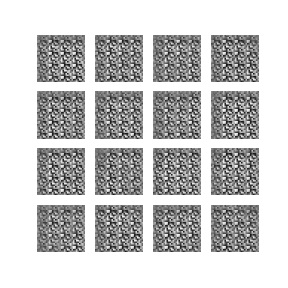

In [4]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

In [ ]:
session.close()